- First set up a simple sentence encoding function for text
- Set up a hyde call to take a question in and return a search result
- Set up a question generator to generate questions as inputs
- Add a relevance extractor to pull the necessary information
- Add a save out for the relevance extractions to the questions
- Add a composer to combine the relevance extractions to a final document

In [1]:
extraction_prompt = """
Task: Identify the relevant sections to the topic, question, and focus I have provided. The topic that the question relates to is {topic} and the focus of my interest is {focus}. The only thing I want you to provide are a list of the citations. The different documents begin with the report number and the title of the report. This report number is the report_id in the citation pattern.

The title is only to provide context for what the report is about. You must not reference it.

Question: {question}

Documents:
{documents}

Instructions:
- Identify only the sections that provide useful information for answering the provided question.
- The citation pattern follows the pattern '([report_id]([section_number]))' as provided in the citation field of the documents. Do not use the brackets in your response, those are only there to indicate what values are in the citation.
- If no relevant sections are found for a question, indicate "No relevant sections found."
- Once the relevant sections are found, provide the citation pattern in a comma separated list.
- Do not introduce your answer, ask follow up questions, or provide a summary or outro. Only provide the list.
- Citations for relevant information must be provided with both the report_id and section_number where the information is from.
- A citation for a section can refer to multiple passages above it. Do not create new citations just because a paragraph or passage does not have a citation immediately after the passage. It'll be found at the end of the section.

Relevant Sections:
"""

query_expansion_prompt = """Task: I have a question about {topic}. I am focusing my research on finding information related the question: {question}. The general direction of this research is based on my focus that I have set forth for broader research: {focus}.

Instructions:
- Write at most two paragraphs that provides an answer to my question in the context of my topic and focus.
- Provide both general terminology and any specific, domain relevant, terms in your answer. This will help me understand the topic and focus on both a high level communicable level and details that provide crucial examples.
- Your answer should not be long. This is meant to get me started, not be a final answer on the subject.

Response Instructions:
- Do not introduce your response or provide a conclusion or summary. Just provide the answer.

Answer: """

search_expansion_prompt = """
Task: Generate 3 focused search questions for me to begin my research with.

Topic: {topic}
Focus: {focus}

Instructions:
- Create 3 questions that address the issues that I should begin my research with.
- Questions should directly address the intersection of the Topic and Focus.
- Prioritize questions that can be answered with factual information by Congressional Research Services reports.
- Do not add color, explanation, intros, outros, justification, or conclusion. Just provide the questions.

Questions:
1.
2.
3.
"""

report_prompt = """Task: I have a topic and a focus for my research that I am writing a report on. My topic is {topic}, and the focus of my research is {focus}. From my initial research, I have compiled a list of relevant sections from different sources.

I need you to extract the relevant information from my sources and organize it into a well structured report that provides all the relevant details, context for the details, all the scenarios and situations discussed in my sources (if there are any).

Instructions:
- First and foremost, you must not add any information, details, or hypotheticals to the report unless they are explicitly discussed in my sources.
- Carefully analyze what the major themes, topics, and situations of the sources are and which are relevant to the focus of my research on my topic.
- It is critical that you do not invent sources.
- It is critical that you provide the citation for each statement, fact, and scenario that you write about in your report.
- Work hierarchically for structuring your report. The main structure of your report should be organized into main sections by theme, followed by subsections containing the important facts, scenarios, any discussion from the sources about that topic, and a final summarization.
- Be thorough and avoid simplification. These are complex topics that I am researching and I need to have all the information available to me.

Sources:
{sources}

Report:
"""

In [2]:
from sentence_transformers import SentenceTransformer
import torch
import lancedb
from lancedb.rerankers import LinearCombinationReranker, RRFReranker
from openai import OpenAI
from collections import defaultdict
import re
import pandas as pd
from pathlib import Path
import json

In [3]:
index = lancedb.connect('../wonky_data/indexes/')
table = index.open_table('sections_fts')
encoder = SentenceTransformer('nomic-ai/nomic-embed-text-v1.5', device='mps',trust_remote_code=True)

!!!!!!!!!!!!megablocks not available, using torch.matmul instead
<All keys matched successfully>


In [4]:
from burr.core import action, State, ApplicationBuilder, ApplicationContext, Action
from burr.core.parallelism import MapStates, RunnableGraph

In [5]:
%load_ext burr.integrations.notebook
%burr_ui

In [6]:
def format_documents(documents):
    formatted_texts = []
    report_ids = list(set([record['id'] for record in documents]))
    for id in report_ids:
        report_sections = [section for section in documents if section['id'] == id]
        report_sections = sorted(report_sections, key=lambda section: section['section_start'])
        report_text = [text['text'] for text in report_sections]
        report_text = [re.sub('\n+', '\n', _text) for _text in report_text]
        report_text = [re.sub(' +', ' ', _text) for _text in report_text]
        report_text = [re.sub(r'(\[.*?\])','', _text) for _text in report_text]
        report_text = [_text.replace('\\','') for _text in report_text]
        report_text = [re.sub(r'(\[.*?\])','', _text) for _text in report_text]
        report_text = [re.sub(r'(\n?-{10,})','', _text) for _text in report_text]
        report_text = [re.sub(r'(\n.*?#_Toc.*?\n)','', _text) for _text in report_text]
        report_text = [re.sub(r'(- \n)','', _text) for _text in report_text]
        report_text = [re.sub(r'\n{2,}','\n', _text) for _text in report_text]
        report_text = [_text.strip() for _text in report_text]
        report_text = '\n-----\n'.join(report_text)
        report_header = f"""**{report_sections[0]['id']}:** {report_sections[0]['title']}"""
        formatted_texts.append(f"""{report_header}\n{report_text}""".strip())
    # print(formatted_texts[0])
    return '\n=======\n'.join(formatted_texts)

client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")
def call_llm(query, temperature=0.3, seed=42, model="gemma-3-4b-it@Q8_0"):
    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "user", "content": query}
        ],
        temperature=temperature,
        seed=seed,
    )
    return completion.choices[0].message.content

import lmstudio as lms
#
# def call_llm(query, temperature=0.3, seed=42, max_tokens=3000, model="gemma-3-4b-it@Q8_0", unload_when_done=False):
#     with lms.Client() as client:
#         model = client.llm.model(model)
#         completion = model.complete(query, config={'temperature': temperature,
#                                                    'max_tokens': max_tokens,
#                                                    'seed': seed})
#         print(completion)
#         content = completion.content
#         if unload_when_done:
#             model.unload()
#         print(content)
#     return content

In [7]:
@action(reads=[], writes=['search_expansion_prompt'])
def search_expansion_prompt_format(state: State, topic: str, focus: str) -> State:
    formatted_prompt = search_expansion_prompt.format(topic=topic,
                                                      focus=focus)
    return state.update(search_expansion_prompt=formatted_prompt)

@action(reads=['search_expansion_prompt'], writes=['search_expansion'])
def search_expansion(state: State) -> State:
    expansion_prompt = state['search_expansion_prompt']
    search_expansion = call_llm(expansion_prompt)
    search_expansion = re.findall(r'\d+\. (.+?\?)', search_expansion)
    return state.update(search_expansion=search_expansion)

In [8]:
@action(reads=['search_expansion'], writes=['query_expansion'])
def query_expansion(state: State, topic: str, focus: str) -> State:
    queries = list()
    for question in state['search_expansion']:
        expansion_prompt = query_expansion_prompt.format(topic=topic,
                                                         focus=focus,
                                                         question=question)
        query_expansion = call_llm(expansion_prompt)
        queries.append({'question': question, 'query': query_expansion})
    return state.update(query_expansion=queries)


In [9]:
@action(reads=['query_expansion'], writes=["query_expansion"])
def embed_text(state: State) -> State:
    query_expansions = list()
    for expansion in state['query_expansion']:
        embedding = encoder.encode(expansion['query'],
                                   padding=False,
                                   show_progress_bar=False).tolist()
        expansion['vector'] = embedding
        query_expansions.append(expansion)
        torch.mps.empty_cache()
    return state.update(query_expansion=query_expansions)

@action(reads=["query_expansion"], writes=["documents"])
def retrieve_documents(state: State, number_of_results: int) -> State:
    expansions = state['query_expansion']
    search_results = list()
    for expansion in expansions:
        query_embedding = expansion["vector"]
        results = table.search(query_type='hybrid')\
            .vector(query_embedding)\
            .text(expansion['query'])\
            .limit(number_of_results)\
            .select(['id','title','text','summary','section_start','section_end'])\
            .to_pandas()

        if 'score' in results.columns:
            results['report_score'] = results.groupby('id')['score'].transform('max')
        elif '_distance' in results.columns:
            results['score'] = 1 - results['_distance']
            results['report_score'] = results.groupby('id')['score'].transform('max')
        elif '_relevance_score' in results.columns:
            results['report_score'] = results['_relevance_score']
        results = results.sort_values(['report_score','section_start'], ascending=[False,True])
        search_results.append(results.to_dict(orient='records'))

    return state.update(documents=search_results)

@action(reads=["query_expansion", "documents"], writes=["extraction_prompt"])
def build_extraction_prompt(state: State, topic: str, focus: str) -> State:
    extraction_prompts = list()
    for _expansion, _documents in zip(state['query_expansion'], state['documents']):
        formatted_documents = format_documents(_documents)
        # print(_expansion)
        prompt = extraction_prompt.format(question=_expansion['question'],
                                          topic=topic,
                                          focus=focus,
                                          documents=formatted_documents)
        extraction_prompts.append(prompt)
    return state.update(extraction_prompt=extraction_prompts)


@action(reads=["extraction_prompt"], writes=["extraction"])
def generate_extraction(state: State) -> State:
    extractions = list()
    for _expansion_prompt in state['extraction_prompt']:
        extraction = call_llm(_expansion_prompt)
        extractions.append(extraction)
    return state.update(extraction=extractions)

In [10]:
@action(reads=["extraction","documents"], writes=["report_grounding", "relevant_citations"])
def merge_grounding(state: State) -> State:
    retrieved_documents = list()
    for result_set in state['documents']:
        retrieved_documents.extend(result_set)
    retrieved_documents = pd.DataFrame(retrieved_documents)
    retrieved_documents = retrieved_documents.drop_duplicates(subset=['id','section_start'], keep='first')
    retrieved_documents = retrieved_documents.sort_values(by=['id','section_start'], ascending=[False,True])
    retrieved_documents = retrieved_documents.to_dict(orient='records')

    relevant_citations = ""
    for extraction in state['extraction']:
        relevant_citations += f", {extraction}"
    relevant_citations = sorted(list(set(re.findall(r'(\w+\(\d+\))', relevant_citations))))

    relevant_sections = list()
    for row in retrieved_documents:
        for citation in relevant_citations:
            if citation in row['text']:
                relevant_sections.append(row)
                break

    return state.update(report_grounding=relevant_sections, relevant_citations=relevant_citations)

@action(reads=["report_grounding"], writes=["formatted_report_grounding", "report_prompt"])
def format_report_prompt(state: State, topic: str, focus: str) -> State:
    grounding = state['report_grounding']
    formatted_grounding = format_documents(grounding)
    formatted_prompt = report_prompt.format(topic=topic,focus=focus, sources=formatted_grounding)
    return state.update(formatted_report_grounding=formatted_grounding, report_prompt=formatted_prompt)

@action(reads=["report_prompt"], writes=["report"])
def generate_report(state: State) -> State:
    report = call_llm(state['report_prompt'], model="gemma-3-12b-it@Q8_0")
    report = report.replace('$','\\$')
    return state.update(report=report)

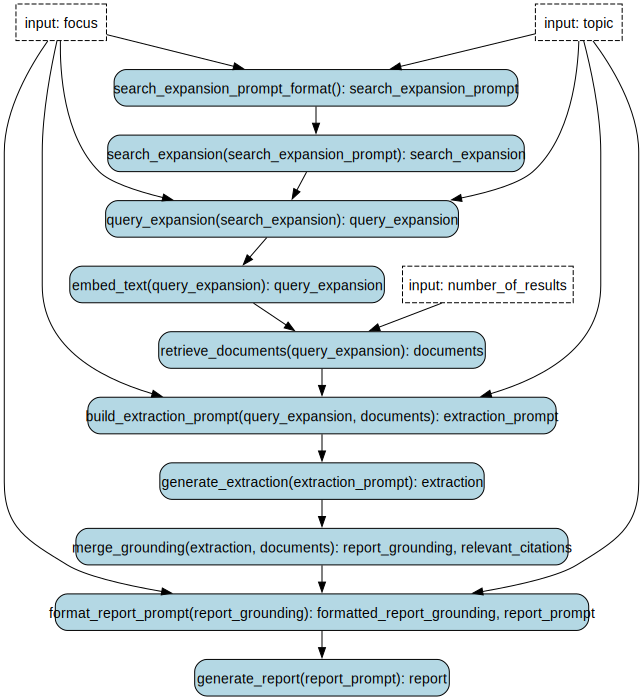

In [11]:
extraction_app = (
    ApplicationBuilder()
    .with_actions(
        search_expansion_prompt_format,
        search_expansion,
        query_expansion,
        embed_text,
        retrieve_documents,
        build_extraction_prompt,
        generate_extraction,
        merge_grounding,
        format_report_prompt,
        generate_report
    )
    .with_transitions(
        ("search_expansion_prompt_format", "search_expansion"),
        ("search_expansion", "query_expansion"),
        ("query_expansion", "embed_text"),
        ("embed_text", "retrieve_documents"),
        ("retrieve_documents", "build_extraction_prompt"),
        ("build_extraction_prompt","generate_extraction"),
        ("generate_extraction","merge_grounding"),
        ("merge_grounding", "format_report_prompt"),
        ("format_report_prompt", "generate_report"))
    .with_entrypoint("search_expansion_prompt_format")
    .with_tracker(
        "local",
        project="burr-report",
    )
    .build()
)
extraction_app.visualize(include_state=True)

In [12]:
topic = "Conditions in South Africa"
focus = "Economic factors impacting South Africa"

In [13]:
extraction_action, extraction_result, extraction_state = extraction_app.run(
    halt_after=["generate_report"],
    inputs={
        "topic": topic,
        "focus": focus,
        "number_of_results": 3
    }
)

In [14]:
extraction_state.get_all()

{'__SEQUENCE_ID': 9,
 'search_expansion_prompt': '\nTask: Generate 3 focused search questions for me to begin my research with.\n\nTopic: Conditions in South Africa\nFocus: Economic factors impacting South Africa\n\nInstructions:\n- Create 3 questions that address the issues that I should begin my research with.\n- Questions should directly address the intersection of the Topic and Focus.\n- Prioritize questions that can be answered with factual information by Congressional Research Services reports.\n- Do not add color, explanation, intros, outros, justification, or conclusion. Just provide the questions.\n\nQuestions:\n1.\n2.\n3.\n',
 '__PRIOR_STEP': 'generate_report',
 'search_expansion': ['What are the primary drivers of income inequality in South Africa?',
  'How have post-apartheid economic policies contributed to unemployment rates in South Africa?',
  'What is the impact of foreign investment on South Africa’s GDP and economic stability?'],
 'query_expansion': [{'question': 'Wh

In [15]:
save_path = Path('wonky_data')
trace_data = save_path.joinpath('data/research_data')
document_data = save_path.joinpath('documents')

In [20]:
from datetime import datetime
short_name = re.findall(r'(\w+)', topic)
short_name = ' '.join([x.lower() for x in short_name[:5]])
short_name = f"{short_name}_{datetime.now().strftime('%Y%m%d%H%M%S')}"

In [21]:
short_name

'conditions in south africa_20250415133529'

In [22]:
short_name

'conditions in south africa_20250415133529'

In [24]:
with open(trace_data.joinpath(short_name + '.json'), 'w') as f:
    json.dump(extraction_state.get_all(), f)

In [28]:
with open(document_data.joinpath(short_name + '.md'), 'w') as f:
    f.write(extraction_state['report'])